# Individual Assignement Théau d'Audiffret 


# Implementation of agents 

In [51]:
import numpy as np
import random
import text_flappy_bird_gym.envs.text_flappy_bird_env_simple as flappy
import text_flappy_bird_gym.envs.text_flappy_bird_env_screen as flappy2

import matplotlib.pyplot as plt
import gymnasium as gym
import os, sys, time


### **Monte Carlo Approach**

The Monte Carlo method is a reinforcement learning technique that relies on sampling complete episodes to estimate the expected return for state-action pairs. In this approach, the agent interacts with the environment and collects data from episodes until termination. The key idea is to calculate the cumulative reward (return) for each state-action pair encountered during an episode and update the action-value function $$ Q(s, a) $$ using the average of these returns over multiple episodes. 

Monte Carlo methods do not require knowledge of the environment's transition dynamics, making them suitable for environments like Text Flappy Bird, where transitions are stochastic and complex. However, a limitation of this approach is that updates can only be made after an episode is completed, which may slow down learning in environments with long or rare terminal states. The policy is improved iteratively by making it greedier with respect to the estimated $$ Q(s, a) $$.






In [79]:
import time

# --- Implementation of the modified Monte Carlo agent with incremental update ---
class MonteCarloAgent:
    def __init__(self, env, epsilon=0.1, gamma=1.0, alpha=0.1, epsilon_decay=0.999, min_epsilon=0.01):
        self.env = env
        self.epsilon = epsilon          # Initial exploration probability
        self.gamma = gamma              # Discount factor
        self.alpha = alpha              # Learning rate
        self.epsilon_decay = epsilon_decay  # Epsilon decay factor at each step
        self.min_epsilon = min_epsilon      # Minimum epsilon value
        self.Q = {}                     # Q-values: key = state, value = array of Q-values for each action
        self.rewards_history = []       # History of cumulative rewards per episode
        self.scores_history = []        # History of scores per episode

    def choose_action(self, state):
        if state not in self.Q:
            self.Q[state] = np.zeros(self.env.action_space.n)
        # Epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.env.action_space.n)
        else:
            action = np.argmax(self.Q[state])
        return action

    def generate_episode(self):
        """
        Generates a complete episode as a list of tuples (state, action, reward).
        At each step, epsilon decays according to epsilon_decay.
        Returns also the final score of the episode.
        """
        episode = []
        state, info = self.env.reset()
        done = False
        final_score = info.get('score', 0)

        while not done:
            action = self.choose_action(state)
            next_state, reward, done, truncated, info = self.env.step(action)
            final_score = info.get('score', final_score)
            episode.append((state, action, reward))
            state = next_state
            # Epsilon decay per step, without going below min_epsilon
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)
            if done:
                break
        return episode, final_score

    def update(self, episode):
        """
        Updates the Q function using the incremental update method (MC Control)
        with learning rate alpha, same as in the EXAMPLE CODE.
        For each (state, action) in the episode, the update is:
            Q(s,a) = Q(s,a) + alpha * (G - Q(s,a))
        where G is the sum of discounted rewards from that point.
        """
        # Decompose the episode into states, actions and rewards
        states, actions, rewards = zip(*episode)
        T = len(rewards)
        # Pre-calculate discount factors
        discounts = np.array([self.gamma**i for i in range(T+1)])
        for i, state in enumerate(states):
            # Compute the discounted sum of rewards from step i
            G = np.sum(np.array(rewards[i:]) * discounts[:T-i])
            self.Q.setdefault(state, np.zeros(self.env.action_space.n))
            self.Q[state][actions[i]] = self.Q[state][actions[i]] + self.alpha * (G - self.Q[state][actions[i]])

    def train(self, num_episodes=1000):
        start_time = time.time()
        for i in range(num_episodes):
            # Stop training if 40 minutes have passed
            if time.time() - start_time > 40 * 60:
                print(f"Training stopped after 40 minutes at Episode {i}")
                break
            episode, final_score = self.generate_episode()
            self.update(episode)
            episode_reward = sum(r for (_, _, r) in episode)
            self.rewards_history.append(episode_reward)
            self.scores_history.append(final_score)
            if (i + 1) % 10000 == 0:
                print(f"Episode {i + 1}/{num_episodes} – Episode length: {len(episode)}")

    def plot_rewards(self):
        """
        Displays the evolution of cumulative rewards over episodes using a moving average.
        """
        plt.figure(figsize=(10, 5))
        window = 1000  # window size for moving average
        if len(self.rewards_history) >= window:
            smoothed_rewards = np.convolve(self.rewards_history, np.ones(window)/window, mode='valid')
            plt.plot(smoothed_rewards, label=f'Rewards (Sliding window of {window} episodes)')
        else:
            plt.plot(self.rewards_history, label='Reward per episode')
        plt.xlabel("Episode")
        plt.ylabel("Cumulative Reward")
        plt.title("Evolution of Cumulative Reward per Episode")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_scores(self):
        """
        Displays the evolution of scores over episodes using a moving average.
        """
        plt.figure(figsize=(10, 5))
        window = 1000  # window size for moving average
        if len(self.scores_history) >= window:
            smoothed_scores = np.convolve(self.scores_history, np.ones(window)/window, mode='valid')
            plt.plot(smoothed_scores, label=f'Scores (Moving average over {window} episodes)')
        else:
            plt.plot(self.scores_history, label='Score per episode')
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.title("Smoothed Evolution of Scores During Training")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_state_value_function(self):
        """
        Constructs and displays the state-value function.
        The value V(s) is computed as the maximum Q-value for a state.
        """
        # Retrieve observation bounds from the environment
        x_space = self.env.observation_space.spaces[0]
        y_space = self.env.observation_space.spaces[1]
        x_vals = range(x_space.n)
        y_vals = range(y_space.start, y_space.start + y_space.n)
        
        # Build a grid for V(s) with y as rows and x as columns
        V = np.zeros((len(y_vals), len(x_vals)))
        for i, y in enumerate(y_vals):
            for j, x in enumerate(x_vals):
                state = (j, y)
                if state in self.Q:
                    V[i, j] = np.max(self.Q[state])
                else:
                    V[i, j] = 0

        plt.figure(figsize=(8, 6))
        plt.imshow(V, origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(label="State Value Function")
        plt.xlabel("Horizontal Distance (x)")
        plt.ylabel("Vertical Distance (y)")
        plt.title("State Value Function")
        plt.show()





## Epsilon importance

Episode 10000/40000 – Episode length: 18
Episode 20000/40000 – Episode length: 8
Episode 30000/40000 – Episode length: 17
Episode 40000/40000 – Episode length: 13


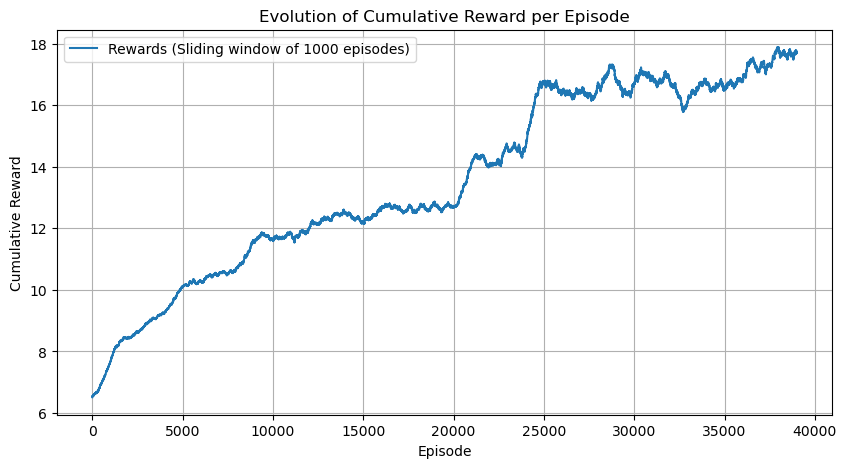

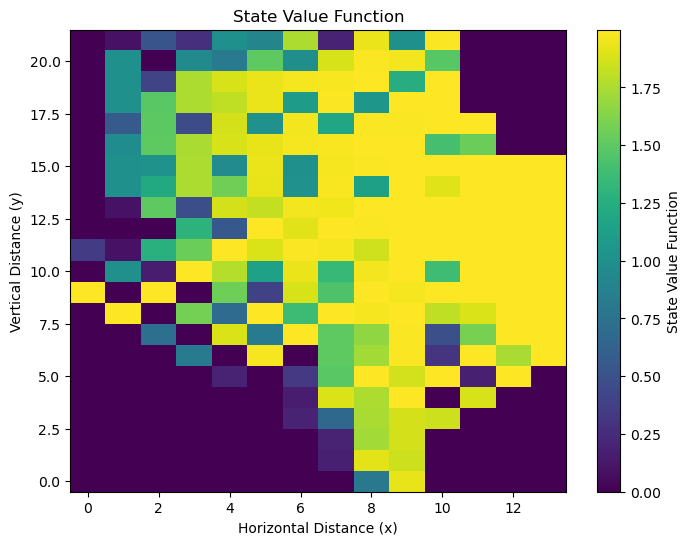

Episode 10000/40000 – Episode length: 83
Episode 20000/40000 – Episode length: 103
Episode 30000/40000 – Episode length: 1413
Episode 40000/40000 – Episode length: 883


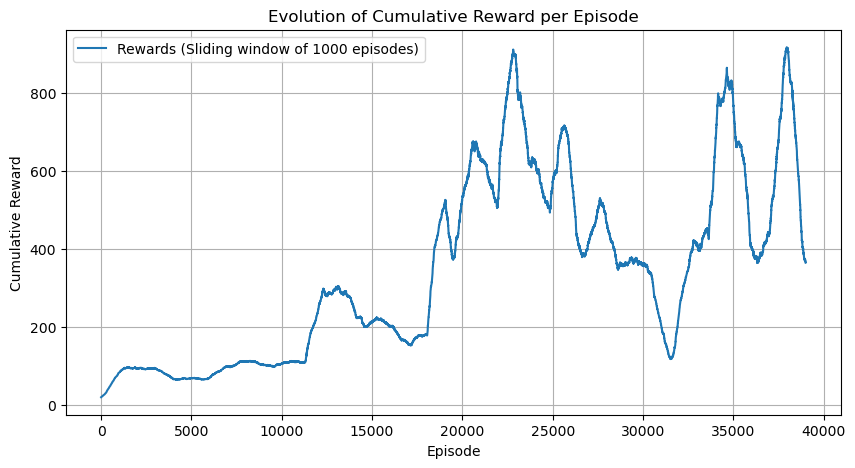

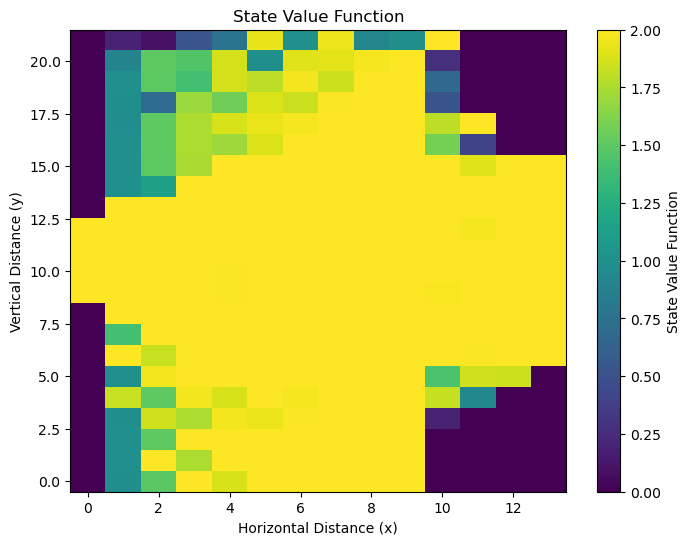

In [53]:
for epsilon in [0.2, 0.8]:
        # Création de l'environnement et entraînement de l'agent
        env = flappy.TextFlappyBirdEnvSimple(height=15, width=20, pipe_gap=4)
        agent = MonteCarloAgent(env, epsilon=epsilon, gamma=0.5, alpha=0.1, epsilon_decay=0.9999, min_epsilon=0.005)
        agent.train(num_episodes=40000)

        # Affichage de l'évolution des récompenses
        agent.plot_rewards()

        # Affichage de l'évolution des scores
        #agent.plot_scores()

        # Affichage de la fonction de valeur des états
        agent.plot_state_value_function()


## Gamma importance 

Episode 10000/40000 – Episode length: 11
Episode 20000/40000 – Episode length: 8
Episode 30000/40000 – Episode length: 13
Episode 40000/40000 – Episode length: 28


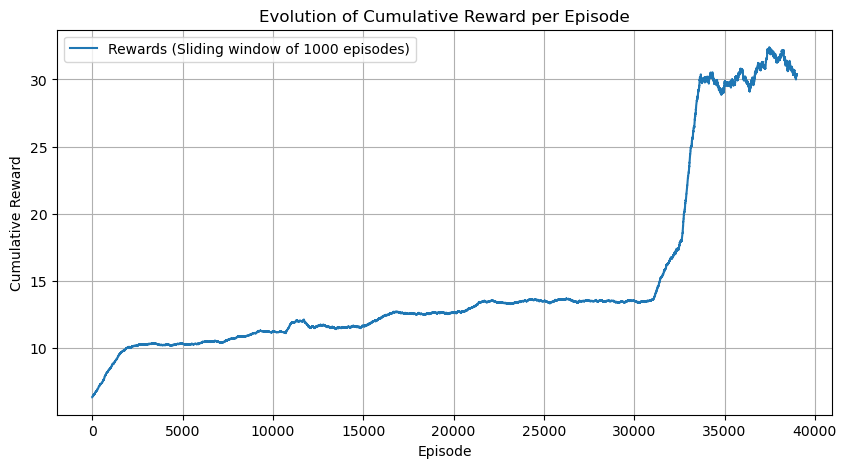

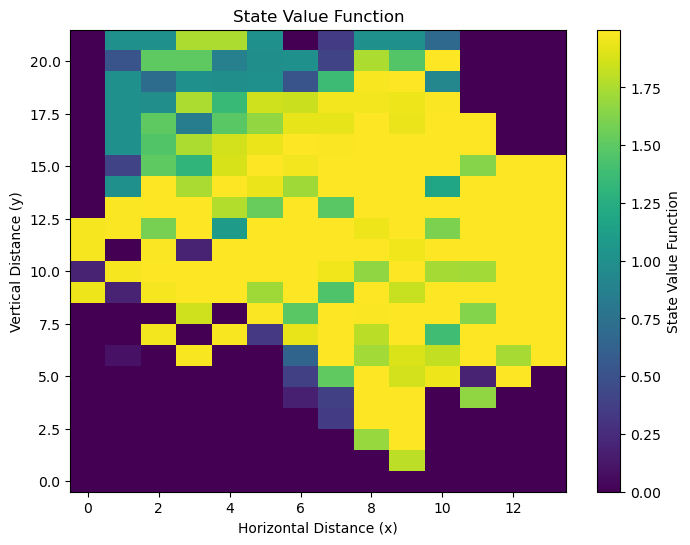

Episode 10000/40000 – Episode length: 23
Episode 20000/40000 – Episode length: 13
Episode 30000/40000 – Episode length: 23
Episode 40000/40000 – Episode length: 13


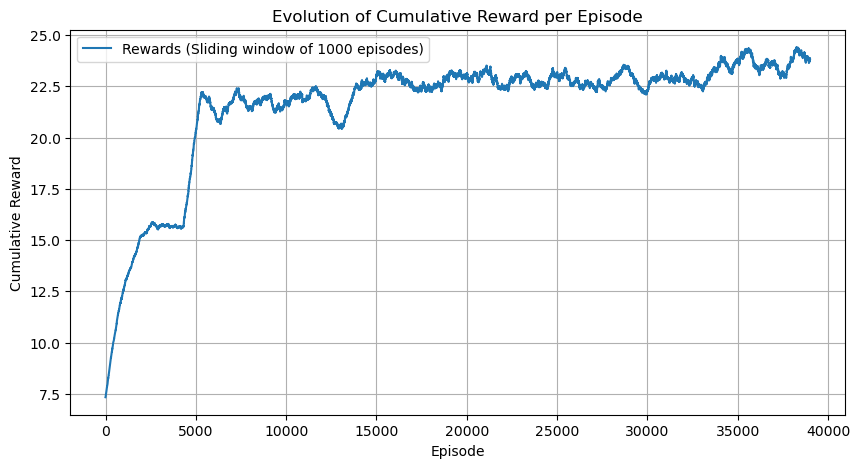

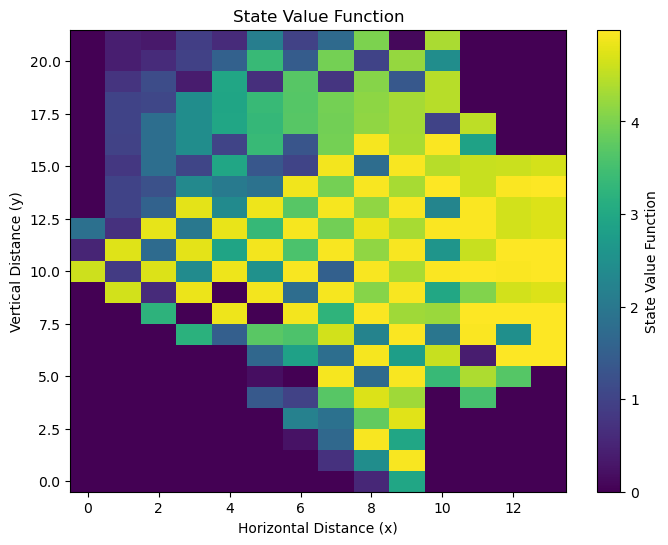

In [54]:
for gamma in [0.5, 0.8]:
        # Création de l'environnement et entraînement de l'agent
        env = flappy.TextFlappyBirdEnvSimple(height=15, width=20, pipe_gap=4)
        agent = MonteCarloAgent(env, epsilon=0.2, gamma=gamma, alpha=0.1, epsilon_decay=0.9999, min_epsilon=0.005)
        agent.train(num_episodes=40000)

        # Affichage de l'évolution des récompenses
        agent.plot_rewards()

        # Affichage de la fonction de valeur des états
        agent.plot_state_value_function()


## Train Monte-Carlo Agent for FB

Episode 10000/140000 – Episode length: 12
Episode 20000/140000 – Episode length: 16
Episode 30000/140000 – Episode length: 23
Episode 40000/140000 – Episode length: 16
Episode 50000/140000 – Episode length: 30
Episode 60000/140000 – Episode length: 13
Episode 70000/140000 – Episode length: 53
Episode 80000/140000 – Episode length: 43
Episode 90000/140000 – Episode length: 53
Episode 100000/140000 – Episode length: 593
Episode 110000/140000 – Episode length: 2493
Episode 120000/140000 – Episode length: 668
Training stopped after 40 minutes at Episode 126424


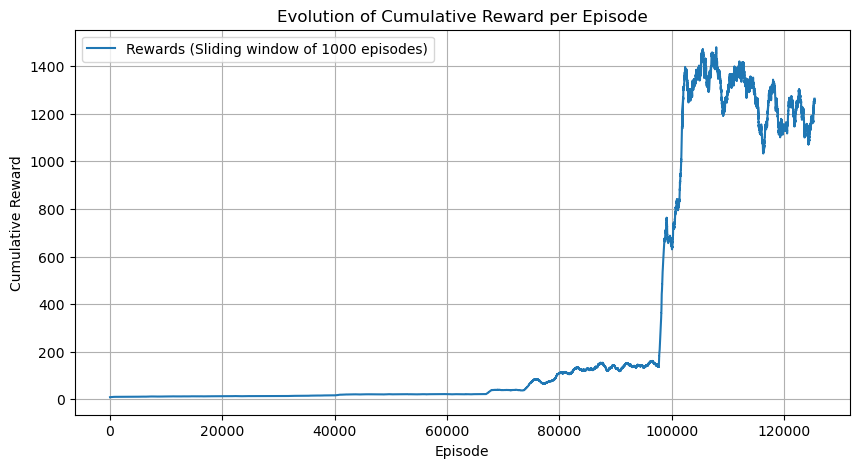

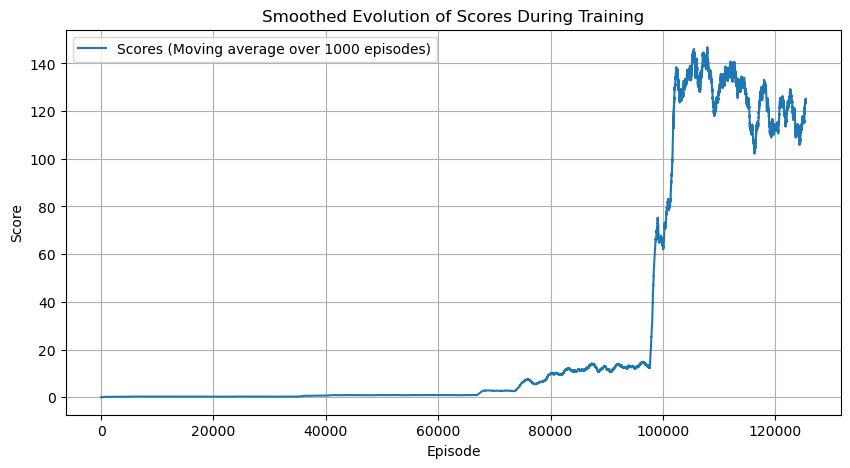

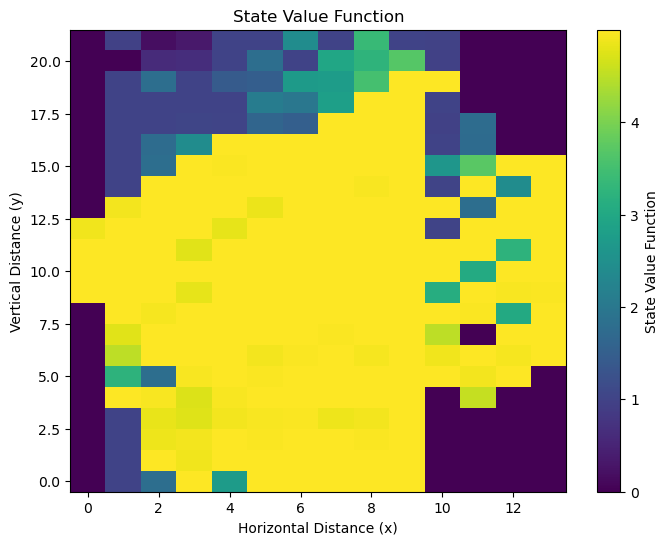

Agent enregistré dans le fichier 'monte_carlo_agent.pkl'.


In [80]:
import pickle


# Create the environment and train the agent
env = flappy.TextFlappyBirdEnvSimple(height=15, width=20, pipe_gap=4)
agent = MonteCarloAgent(env, epsilon=0.3, gamma=0.8, alpha=0.1, epsilon_decay=0.999, min_epsilon=0.005)
agent.train(num_episodes=140000)

# Display the evolution of rewards
agent.plot_rewards()

# Display the evolution of scores
agent.plot_scores()

# Display the state-value function
agent.plot_state_value_function()

# Sauvegarde de l'agent dans un fichier
def save_agent(agent, filename="monte_carlo_agent.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(agent, f)
    print(f"Agent enregistré dans le fichier '{filename}'.")
save_agent(agent, filename="monte_carlo_agent.pkl")


def load_agent(filename="monte_carlo_agent.pkl"):
    with open(filename, "rb") as f:
        agent = pickle.load(f)
    return agent





## Results

In [94]:
obs, _ = env.reset()

# Chargement de l'agent enregistré
agent = load_agent("monte_carlo_agent.pkl")


# Boucle de jeu
old_score = 0

while True:
    # L'agent sélectionne l'action à partir de l'observation courante
    action = agent.choose_action(obs)
    
    # Exécution de l'action dans l'environnement
    obs, reward, done, _, info = env.step(action)
    score = info.get('score', 0)
    if score > old_score:
        os.system("clear")
        sys.stdout.write(env.render())
        old_score = score
    print(f"Score: {info.get('score', 0)}")
    time.sleep(0.01)  # Contrôle de la fréquence d'affichage (FPS)
    
    # Fin de l'épisode si le joueur est mort
    if done:
        break

env.close()

Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Text Flappy Bird!
Score: 1
----------------------
[     |         |    ]
[               |    ]
[               |    ]
[      @        |    ]
[               |    ]
[     |              ]
[     |              ]
[     |              ]
[     |              ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=9,dy=-4)
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Text Flappy Bird!
Score: 2
----------------------
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[               |    ]
[                    ]
[      @             ]
[                    ]
[     |              ]
[     |         |    ]
[     |         |  

# SARSA



### **SARSA(λ) Approach**

SARSA(λ) is an advanced on-policy reinforcement learning algorithm that combines the SARSA method with eligibility traces to improve learning efficiency. This approach updates the action-value function $ Q(s, a) $ incrementally during each step of an episode based on the current policy and incorporates traces of past state-action pairs weighted by a decay factor $ \lambda $. The eligibility traces allow SARSA(λ) to propagate reward signals more effectively across states, enabling faster convergence in environments with delayed rewards. By combining exploration and exploitation through an $ \epsilon $-greedy policy, SARSA(λ) iteratively improves its policy while leveraging temporal credit assignment. This makes it well-suited for dynamic environments like Text Flappy Bird.




In [57]:
import numpy as np
import matplotlib.pyplot as plt

class SARSAAgent:
    def __init__(self, env, epsilon=0.1, gamma=1.0, alpha=0.1, epsilon_decay=0.999, min_epsilon=0.01, lambda_=0.1):
        self.env = env
        self.epsilon = epsilon            # Initial exploration probability
        self.gamma = gamma                # Discount factor
        self.alpha = alpha                # Learning rate
        self.epsilon_decay = epsilon_decay  # Epsilon decay at each step
        self.min_epsilon = min_epsilon      # Minimum epsilon value
        self.lambda_ = lambda_            # Eligibility trace coefficient
        self.Q = {}                       # Q-values: key = state, value = Q-value array for each action
        self.rewards_history = []         # Cumulative rewards history per episode
        self.scores_history = []          # Scores history per episode

    def choose_action(self, state):
        # Initialize Q for the state if necessary
        if state not in self.Q:
            self.Q[state] = np.zeros(self.env.action_space.n)
        # Epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)
        else:
            return np.argmax(self.Q[state])

    def train(self, num_episodes=1000):
        for i in range(num_episodes):
            state, info = self.env.reset()
            done = False
            final_score = info.get('score', 0)
            episode_reward = 0
            steps = 0

            # Initialize eligibility traces for the current episode
            E = {}
            if state not in self.Q:
                self.Q[state] = np.zeros(self.env.action_space.n)
            # Initialize the trace for the current state
            E[state] = np.zeros(self.env.action_space.n)
            
            # Choose the initial action
            action = self.choose_action(state)
            
            while not done:
                next_state, reward, done, truncated, info = self.env.step(action)
                final_score = info.get('score', final_score)
                episode_reward += reward
                steps += 1

                # Initialize Q and trace for the next state if necessary
                if next_state not in self.Q:
                    self.Q[next_state] = np.zeros(self.env.action_space.n)
                if next_state not in E:
                    E[next_state] = np.zeros(self.env.action_space.n)
                
                # Choose the next action (if episode not finished)
                next_action = self.choose_action(next_state) if not done else None

                # Calculate the TD error
                current_Q = self.Q[state][action]
                next_Q = self.Q[next_state][next_action] if not done else 0.0
                delta = reward + self.gamma * next_Q - current_Q

                # Update the eligibility trace for the state-action pair
                E[state][action] += 1  # Accumulated trace

                # Update all Q-values according to their trace and decay the trace
                for s in list(E.keys()):
                    self.Q[s] += self.alpha * delta * E[s]
                    E[s] = self.gamma * self.lambda_ * E[s]
                
                # Move to the next state and action
                state = next_state
                action = next_action

                # Decay epsilon at each step
                self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)
            
            self.rewards_history.append(episode_reward)
            self.scores_history.append(final_score)
            if (i + 1) % 10000 == 0:
                print(f"Episode {i + 1}/{num_episodes} – Episode length: {steps}")

    def plot_rewards(self):
        """
        Displays the evolution of cumulative rewards over episodes using a moving average.
        """
        plt.figure(figsize=(10, 5))
        window = 1000  # window size for moving average
        if len(self.rewards_history) >= window:
            smoothed_rewards = np.convolve(self.rewards_history, np.ones(window)/window, mode='valid')
            plt.plot(smoothed_rewards, label=f'Reward (Moving Average over {window} episodes)')
        else:
            plt.plot(self.rewards_history, label='Reward per episode')
        plt.xlabel("Episode")
        plt.ylabel("Cumulative Reward")
        plt.title("Smoothed evolution of rewards during training")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_scores(self):
        """
        Displays the evolution of scores over episodes using a moving average.
        """
        plt.figure(figsize=(10, 5))
        window = 1000  # window size for moving average
        if len(self.scores_history) >= window:
            smoothed_scores = np.convolve(self.scores_history, np.ones(window)/window, mode='valid')
            plt.plot(smoothed_scores, label=f'Score (Moving Average over {window} episodes)')
        else:
            plt.plot(self.scores_history, label='Score per episode')
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.title("Smoothed evolution of scores during training")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_state_value_function(self):
        """
        Constructs and displays the state-value function.
        The value V(s) is computed as the maximum Q-value for a state.
        """
        # Get the observation bounds from the environment
        x_space = self.env.observation_space.spaces[0]
        y_space = self.env.observation_space.spaces[1]
        x_vals = range(x_space.n)
        y_vals = range(y_space.start, y_space.start + y_space.n)
        
        # Build a grid for V(s) with y as rows and x as columns
        V = np.zeros((len(y_vals), len(x_vals)))
        for i, y in enumerate(y_vals):
            for j, x in enumerate(x_vals):
                state = (j, y)
                if state in self.Q:
                    V[i, j] = np.max(self.Q[state])
                else:
                    V[i, j] = 0

        plt.figure(figsize=(8, 6))
        plt.imshow(V, origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(label="State Value")
        plt.xlabel("Horizontal Distance (x)")
        plt.ylabel("Vertical Distance (y)")
        plt.title("State Value Function")
        plt.show()




## Epsilon importance 

Episode 10000/60000 – Episode length: 6
Episode 20000/60000 – Episode length: 7
Episode 30000/60000 – Episode length: 19
Episode 40000/60000 – Episode length: 6
Episode 50000/60000 – Episode length: 27
Episode 60000/60000 – Episode length: 18


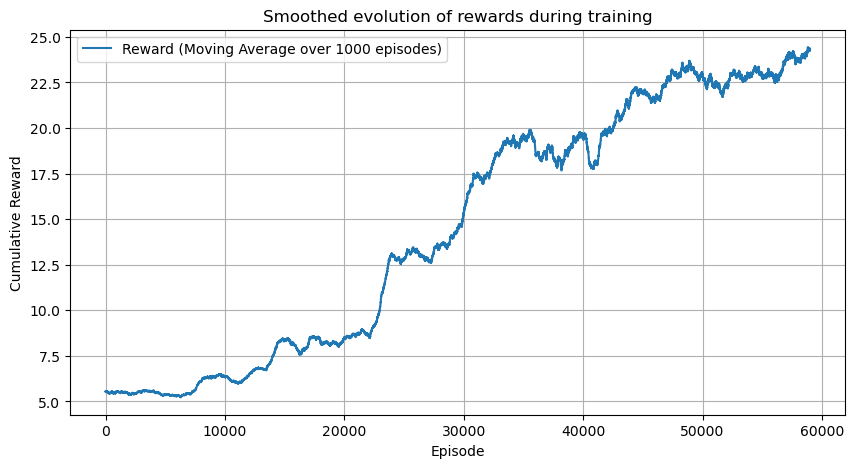

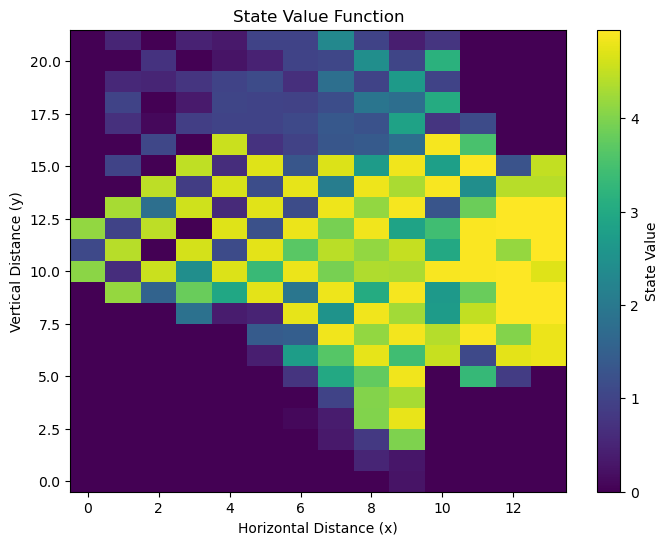

Episode 10000/60000 – Episode length: 5
Episode 20000/60000 – Episode length: 7
Episode 30000/60000 – Episode length: 9
Episode 40000/60000 – Episode length: 9
Episode 50000/60000 – Episode length: 8
Episode 60000/60000 – Episode length: 10


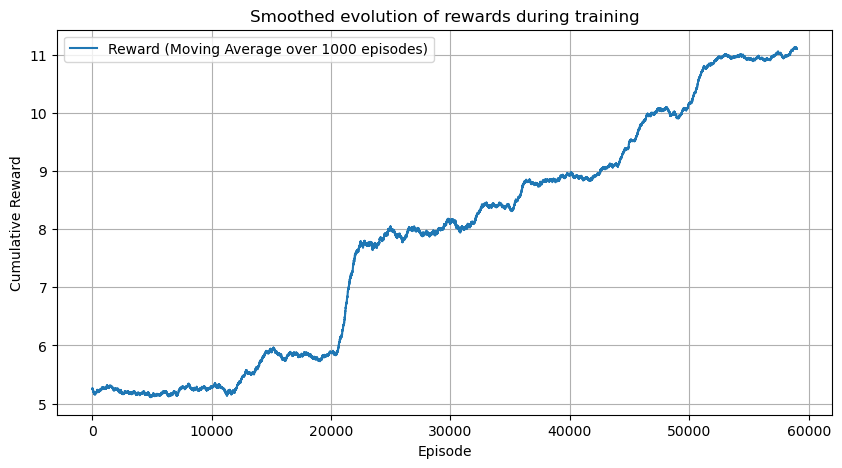

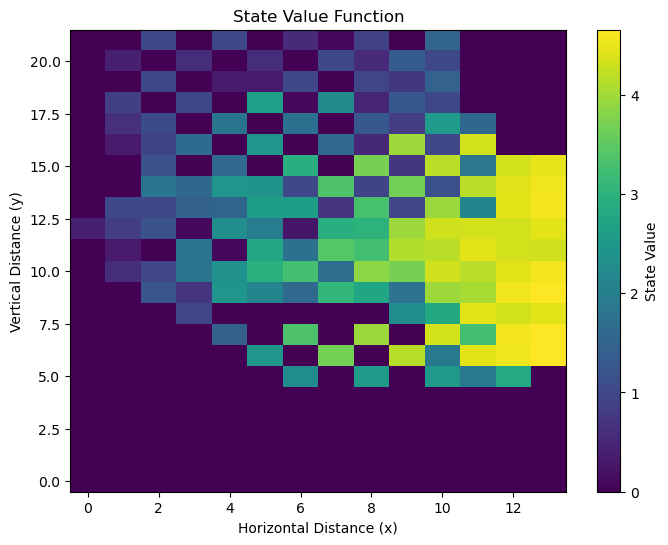

In [60]:
for epsilon in [0.2, 0.8]:
    # Création de l'environnement et entraînement de l'agent SARSA(λ)
    env = flappy.TextFlappyBirdEnvSimple(height=15, width=20, pipe_gap=4)
    agent = SARSAAgent(env, epsilon=0.2, gamma=0.8, alpha=0.1, epsilon_decay=0.999, min_epsilon=0.005, lambda_=0.1)
    agent.train(num_episodes=60000)

    # Affichage de l'évolution des récompenses
    agent.plot_rewards()

    # Affichage de l'évolution des scores
    # agent.plot_scores()

    # Affichage de la fonction de valeur des états
    agent.plot_state_value_function()


## Gamma importance

Episode 10000/70000 – Episode length: 4
Episode 20000/70000 – Episode length: 6
Episode 30000/70000 – Episode length: 6
Episode 40000/70000 – Episode length: 12
Episode 50000/70000 – Episode length: 7
Episode 60000/70000 – Episode length: 13
Episode 70000/70000 – Episode length: 13


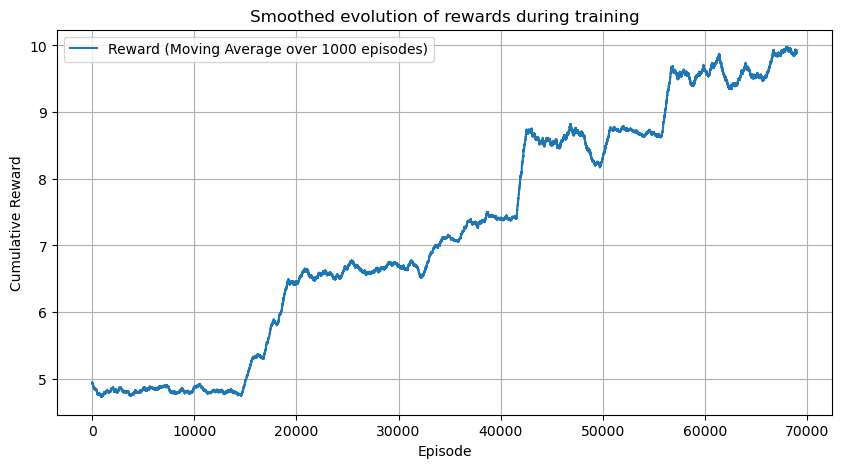

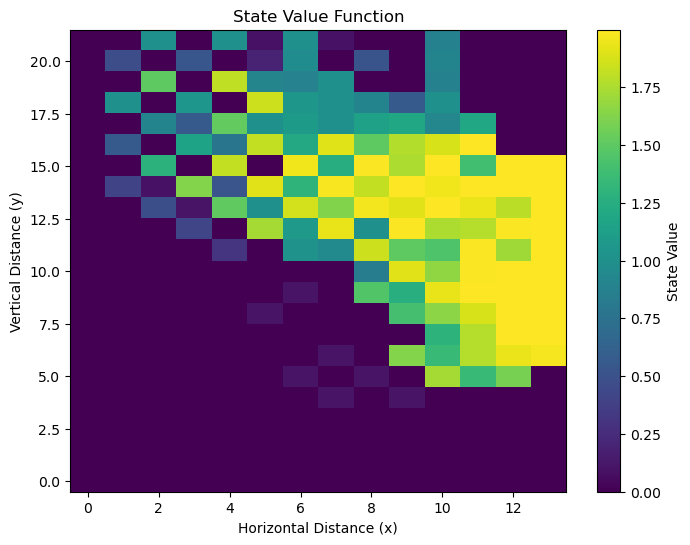

Episode 10000/70000 – Episode length: 4
Episode 20000/70000 – Episode length: 4
Episode 30000/70000 – Episode length: 8
Episode 40000/70000 – Episode length: 6
Episode 50000/70000 – Episode length: 17
Episode 60000/70000 – Episode length: 18
Episode 70000/70000 – Episode length: 27


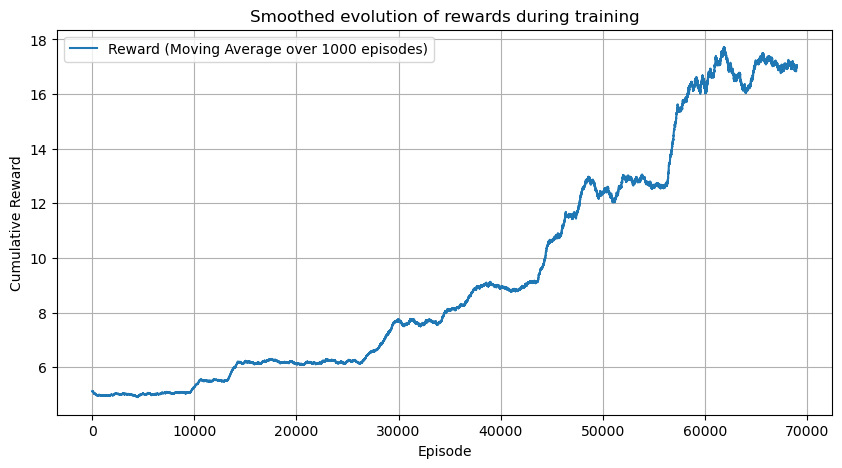

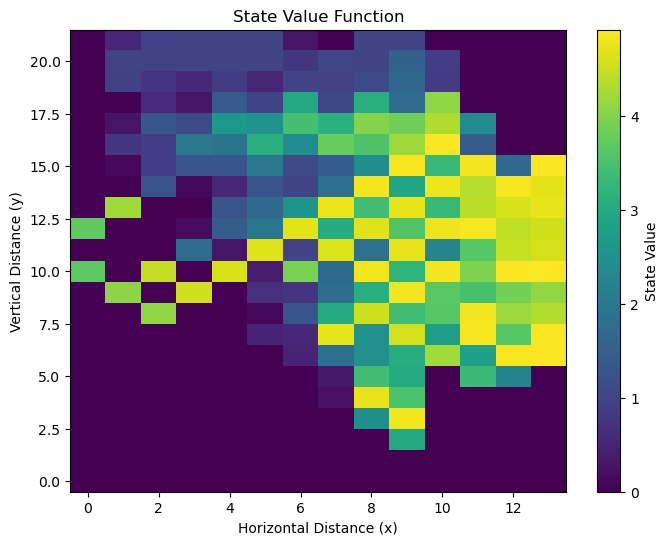

In [66]:
for gamma in [0.5, 0.8]:
    # Création de l'environnement et entraînement de l'agent SARSA(λ)
    env = flappy.TextFlappyBirdEnvSimple(height=15, width=20, pipe_gap=4)
    agent = SARSAAgent(env, epsilon=0.2, gamma=gamma, alpha=0.1, epsilon_decay=0.999, min_epsilon=0.005, lambda_=0.1)
    agent.train(num_episodes=70000)

    # Affichage de l'évolution des récompenses
    agent.plot_rewards()

    # Affichage de l'évolution des scores
    # agent.plot_scores()

    # Affichage de la fonction de valeur des états
    agent.plot_state_value_function()


## Lambda importance

Episode 10000/80000 – Episode length: 5
Episode 20000/80000 – Episode length: 7
Episode 30000/80000 – Episode length: 8
Episode 40000/80000 – Episode length: 13
Episode 50000/80000 – Episode length: 13
Episode 60000/80000 – Episode length: 13
Episode 70000/80000 – Episode length: 26
Episode 80000/80000 – Episode length: 13


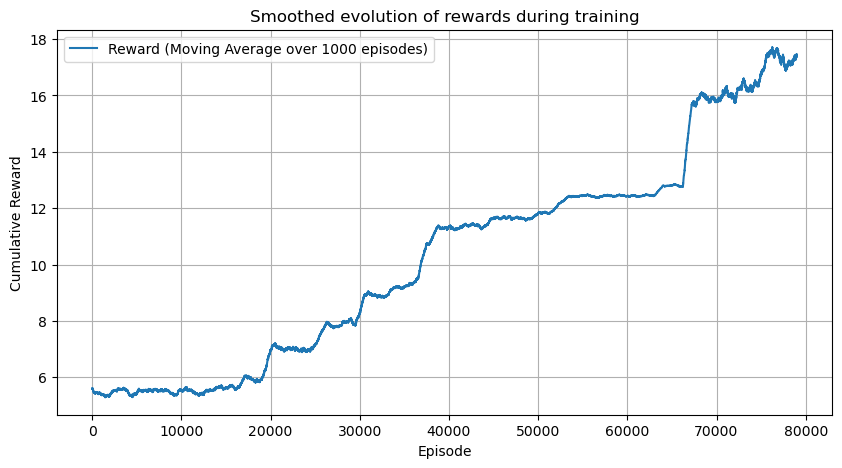

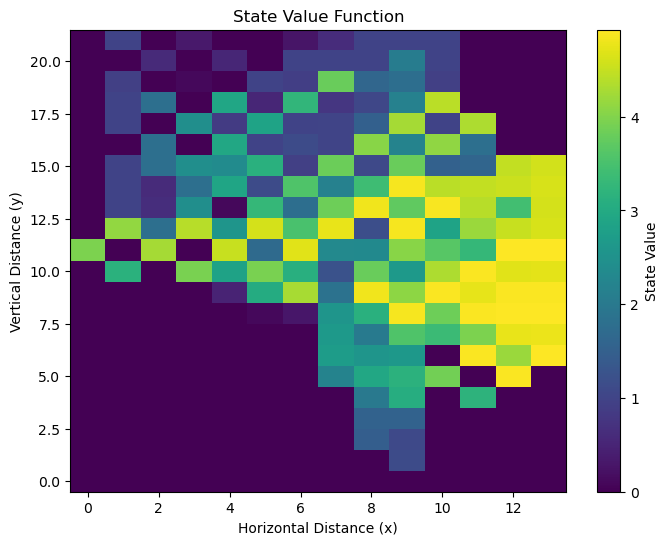

Episode 10000/80000 – Episode length: 10
Episode 20000/80000 – Episode length: 7
Episode 30000/80000 – Episode length: 11
Episode 40000/80000 – Episode length: 12
Episode 50000/80000 – Episode length: 14
Episode 60000/80000 – Episode length: 33
Episode 70000/80000 – Episode length: 276
Episode 80000/80000 – Episode length: 568


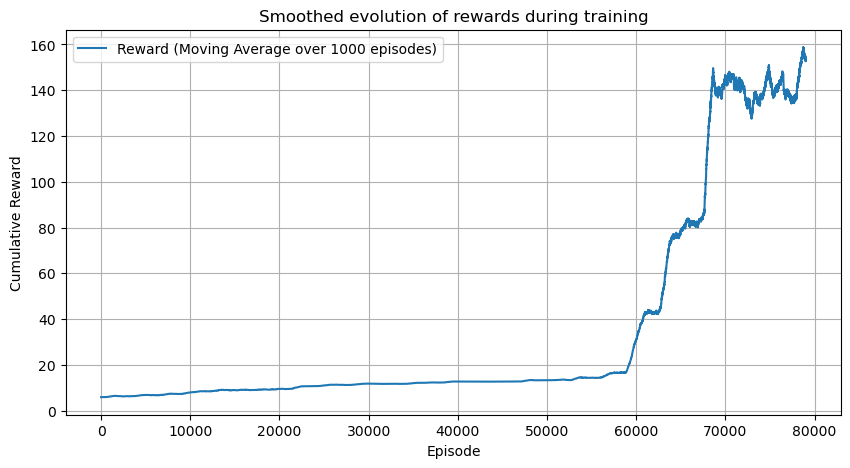

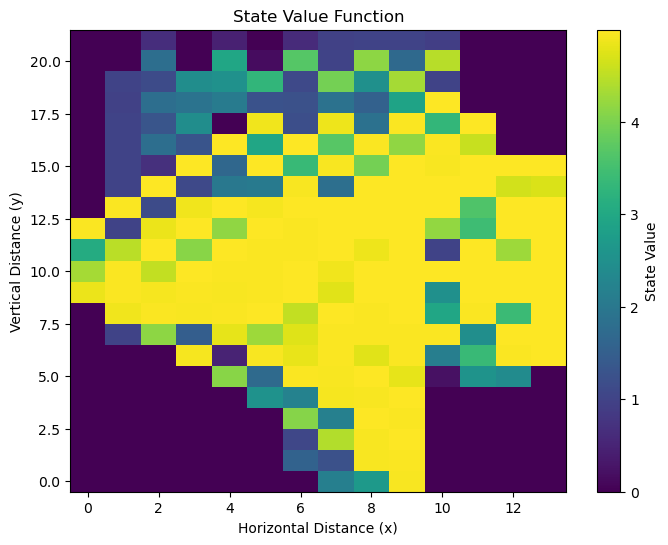

In [65]:
for lambda_ in [0.1, 0.9]:
    # Création de l'environnement et entraînement de l'agent SARSA(λ)
    env = flappy.TextFlappyBirdEnvSimple(height=15, width=20, pipe_gap=4)
    agent = SARSAAgent(env, epsilon=0.2, gamma=0.8, alpha=0.1, epsilon_decay=0.999, min_epsilon=0.005, lambda_=lambda_)
    agent.train(num_episodes=80000)

    # Affichage de l'évolution des récompenses
    agent.plot_rewards()

    # Affichage de l'évolution des scores
    # agent.plot_scores()

    # Affichage de la fonction de valeur des états
    agent.plot_state_value_function()


## Trainning SARSA agent for FB 

Episode 10000/110000 – Episode length: 7
Episode 20000/110000 – Episode length: 8
Episode 30000/110000 – Episode length: 13
Episode 40000/110000 – Episode length: 13
Episode 50000/110000 – Episode length: 13
Episode 60000/110000 – Episode length: 16
Episode 70000/110000 – Episode length: 22
Episode 80000/110000 – Episode length: 20
Episode 90000/110000 – Episode length: 1006
Episode 100000/110000 – Episode length: 2768
Episode 110000/110000 – Episode length: 683


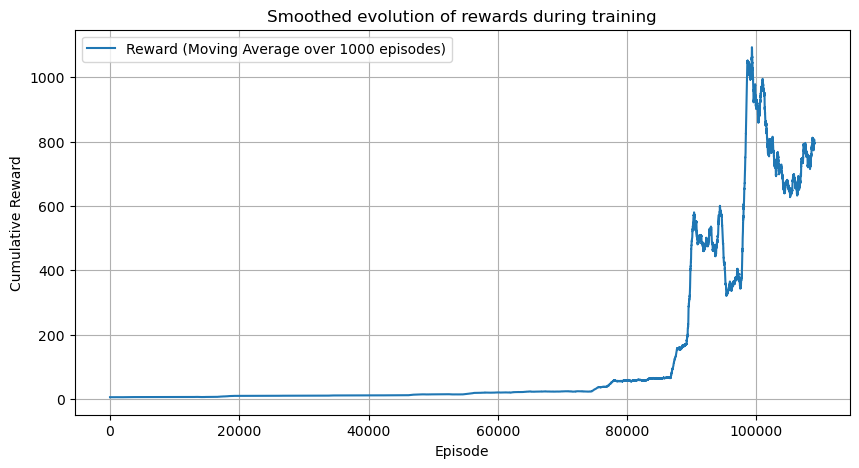

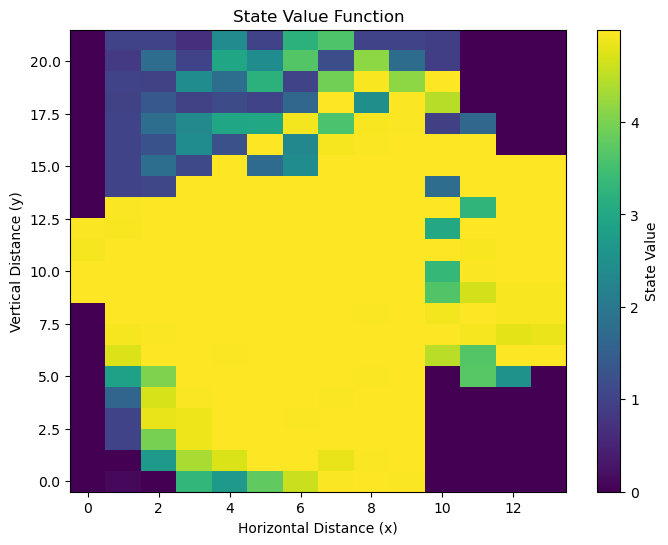

Agent enregistré dans le fichier 'sarsa_lamb_agent.pkl'.


In [68]:
# Create the environment and train the SARSA(λ) agent
env = flappy.TextFlappyBirdEnvSimple(height=15, width=20, pipe_gap=4)
agent = SARSAAgent(env, epsilon=0.2, gamma=0.8, alpha=0.1, epsilon_decay=0.999, min_epsilon=0.005, lambda_=0.8)
agent.train(num_episodes=110000)

# Display the evolution of rewards
agent.plot_rewards()

# Display the evolution of scores
# agent.plot_scores()

# Display the state value function
agent.plot_state_value_function()



# Sauvegarde de l'agent dans un fichier
def save_agent(agent, filename="sarsa_lamb_agent.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(agent, f)
    print(f"Agent enregistré dans le fichier '{filename}'.")
save_agent(agent, filename="sarsa_lamb_agent.pkl")


def load_agent(filename="sarsa_lamb_agent.pkl"):
    with open(filename, "rb") as f:
        agent = pickle.load(f)
    return agent


## Results

In [92]:
obs, _ = env.reset()

# Chargement de l'agent enregistré
agent = load_agent("sarsa_lamb_agent.pkl")


# Boucle de jeu
old_score = 0

while True:
    # L'agent sélectionne l'action à partir de l'observation courante
    action = agent.choose_action(obs)
    
    # Exécution de l'action dans l'environnement
    obs, reward, done, _, info = env.step(action)
    score = info.get('score', 0)
    if score > old_score:
        os.system("clear")
        sys.stdout.write(env.render())
        old_score = score
    print(f"Score: {info.get('score', 0)}")
    time.sleep(0.001)  # Contrôle de la fréquence d'affichage (FPS)
    
    # Fin de l'épisode si le joueur est mort
    if done:
        break

env.close()

Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Text Flappy Bird!
Score: 1
----------------------
[     |@        |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[     |              ]
[     |              ]
[     |              ]
[     |              ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=9,dy=-7)
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Score: 1
Text Flappy Bird!
Score: 2
----------------------
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[               |    ]
[               |    ]
[      @        |    ]
[               |    ]
[     |              ]
[     |              ]
[     |            